In [1]:
!nvidia-smi

Tue Jul 13 14:13:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 51%   47C    P0   114W / 380W |   1052MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импортирование библиотек

In [2]:
import cv2
from datetime import datetime
from tqdm import tqdm
from PIL import ImageOps, ImageFilter
import PIL
import os
import sys
import random as rn
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, \
                                    ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, \
                                    Activation, Lambda, BatchNormalization,SeparableConv2D,\
                                    GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Функции

In [4]:
def plot(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [6]:
def print_all_classes():
    
    
    '''Вывод 1й картинки каждого класса машин'''

    
    cols = 5
    rows = 2
    fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))

    count = 0
    for i in range(cols):
        for j in range(rows):
            if count <5:
                image = PIL.Image.open(
                    path_train+'NORMAL/'+os.listdir(path_train+'NORMAL/')[count],
                    formats=['JPEG'])
            else:
                image = PIL.Image.open(
                    path_train+'PNEUMONIA/'+os.listdir(path_train+'PNEUMONIA/')[count],
                    formats=['JPEG'])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image, cmap='gray')
            if count <5:
                ax.set_title(f'Category: NORMAL')
            else:
                ax.set_title(f'Category: PNEUMONIA')
            count += 1

    plt.show()

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n][1]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [8]:
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image



def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0])
    
    base_pred = [i.argmax() for i in base_pred]
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, base_pred))
    matrix=confusion_matrix(actual_label, base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

# Инициализация переменных

In [9]:
path_train = 'B:/SKILL_FACTORY/chest_xray/train/'
path_train_norm = 'B:/SKILL_FACTORY/chest_xray/train/NORMAL/'
path_train_pn = 'B:/SKILL_FACTORY/chest_xray/train/PNEUMONIA/'

path_test = 'B:/SKILL_FACTORY/chest_xray/test/'
path_test_norm = 'B:/SKILL_FACTORY/chest_xray/test/NORMAL/'
path_test_pn = 'B:/SKILL_FACTORY/chest_xray/test/PNEUMONIA/'

path_val = 'B:/SKILL_FACTORY/chest_xray/val/'
path_val_norm = 'B:/SKILL_FACTORY/chest_xray/val/NORMAL/'
path_val_pn = 'B:/SKILL_FACTORY/chest_xray/val/PNEUMONIA/'

IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG = IMG_SIZE * IMG_SIZE
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
EPOCHS = 500

# Reproducibility

# EDA + Подготовка данных

In [10]:
sum_train = len(os.listdir(path_train_norm)) + len(os.listdir(path_train_pn))
sum_test = len(os.listdir(path_test_norm)) + len(os.listdir(path_test_pn))
sum_val = len(os.listdir(path_val_norm)) + len(os.listdir(path_val_pn))

print(f'( {len(os.listdir(path_train_norm))} , {round(len(os.listdir(path_train_norm))/sum_train,2)} ) || ( {len(os.listdir(path_train_pn))} , {round(len(os.listdir(path_train_pn))/sum_train,2)} )  {sum_train}')
print(f'( {len(os.listdir(path_test_norm))} , {round(len(os.listdir(path_test_norm))/sum_test,2)} ) || ( {len(os.listdir(path_test_pn))} , {round(len(os.listdir(path_test_pn))/sum_test,2)} )  {sum_test}')
print(f'( {len(os.listdir(path_val_norm))} , {round(len(os.listdir(path_val_norm))/sum_val,2)} ) || ( {len(os.listdir(path_test_norm))} , {round(len(os.listdir(path_val_pn))/sum_val,2)} )   {sum_val}')

( 1341 , 0.26 ) || ( 3875 , 0.74 )  5216
( 234 , 0.38 ) || ( 390 , 0.62 )  624
( 8 , 0.5 ) || ( 234 , 0.5 )   16


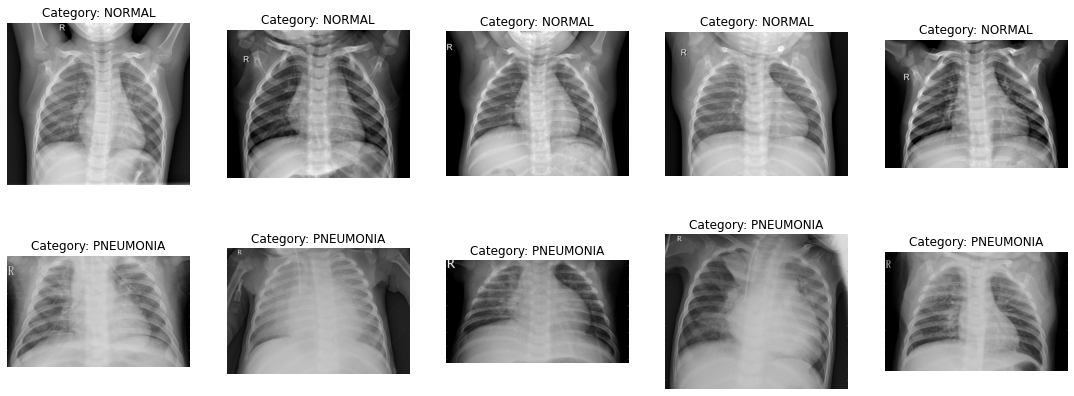

In [11]:
print_all_classes()

In [12]:
norm_tr = len(os.listdir(path_train_norm))
pneum_tr = len(os.listdir(path_train_pn))

norm_t = len(os.listdir(path_test_norm))
pneum_t = len(os.listdir(path_test_pn))

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=[0.7,1.3],
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.2],
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    path_val,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


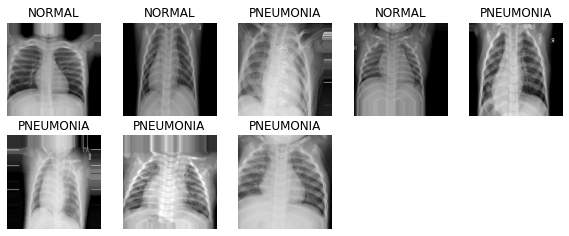

In [14]:
image_batch, label_batch = next(iter(train_generator))

show_batch(image_batch, label_batch)

In [15]:
test_data = []
for filename in os.listdir(path_test_norm):
    test_data.append((os.path.join(path_test_norm,filename),0))
    
for filename in os.listdir(path_test_pn):
    test_data.append((os.path.join(path_test_pn,filename),1))    
    
    

test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)

# Построение модели

## 1) DenseNet201 (с заморозкой всех весов)

In [15]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)

In [16]:
tf.keras.backend.clear_session()
base_DenseNet201 = DenseNet201(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

base_DenseNet201.trainable = False

len(base_DenseNet201.trainable_variables)

0

In [17]:
densenet_model = Sequential(name = "DenseNet201")
densenet_model.add(base_DenseNet201)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(2, activation='sigmoid'))

In [18]:
densenet_model.summary()

Model: "DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               

In [19]:
densenet_model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_DenseNet201 = ModelCheckpoint('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_DenseNet201 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [20]:
for layer in densenet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B039E439C8> --> False 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A48A908> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B03A48AA08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B03A48FF88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A4001C8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B039FC9B08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039FC9AC8> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A411F48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039BB0708> --> True 



In [21]:
densenet_history = densenet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_DenseNet201, earlystop_DenseNet201])

Epoch 1/500
652/652 [==============================] - 218s 310ms/step - loss: 0.3909 - accuracy: 0.8275 - val_loss: 0.2521 - val_accuracy: 0.9038

Epoch 00001: val_accuracy improved from -inf to 0.90385, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 2/500
652/652 [==============================] - 150s 230ms/step - loss: 0.2421 - accuracy: 0.8988 - val_loss: 0.2477 - val_accuracy: 0.9119

Epoch 00002: val_accuracy improved from 0.90385 to 0.91186, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 3/500
652/652 [==============================] - 150s 229ms/step - loss: 0.2491 - accuracy: 0.8939 - val_loss: 0.2279 - val_accuracy: 0.9135

Epoch 00003: val_accuracy improved from 0.91186 to 0.91346, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 4/500
652/652 [==============================] - 148s 226ms/step - loss: 0.2241 - accuracy: 0.9059 - val_loss: 0.2409 - val_accuracy: 0.

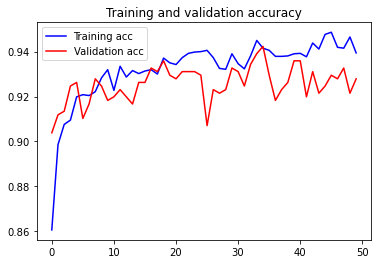

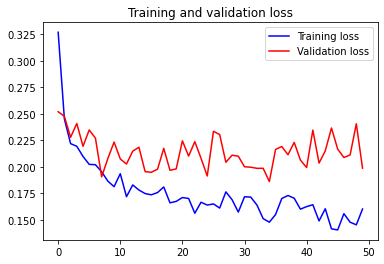

In [22]:
plot(densenet_history)

In [23]:
densenet_model.save('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201_1_1.h5')
densenet_model.load_weights('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5')

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       234
           1       0.94      0.96      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



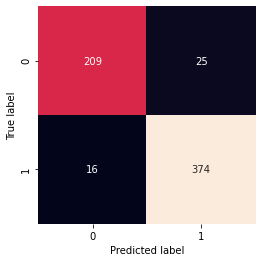

In [24]:
testing(densenet_model, test_df)

## 2) Обучение модели с FineTuning - обучение 1/4 весов

In [25]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [26]:
print("Коо-во слоёв в base_model: ", len(base_DenseNet201.layers))

Коо-во слоёв в base_model:  707


In [27]:
base_DenseNet201.trainable = True

fine_tune_at = int(len(base_DenseNet201.layers)*0.75)

for layer in base_DenseNet201.layers[:fine_tune_at]:
    layer.trainable = False

In [28]:
len(base_DenseNet201.trainable_variables)

152

In [29]:
for layer in densenet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B039E439C8> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A48A908> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B03A48AA08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B03A48FF88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A4001C8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B039FC9B08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039FC9AC8> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A411F48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039BB0708> --> True 



In [30]:
densenet_model.summary()

Model: "DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               

In [31]:
densenet_model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_DenseNet201 = ModelCheckpoint('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_DenseNet201 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [32]:
densenet_history = densenet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_DenseNet201, earlystop_DenseNet201])

Epoch 1/500
652/652 [==============================] - 165s 232ms/step - loss: 0.3167 - accuracy: 0.8849 - val_loss: 0.3428 - val_accuracy: 0.8846

Epoch 00001: val_accuracy improved from -inf to 0.88462, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 2/500
652/652 [==============================] - 149s 228ms/step - loss: 0.1894 - accuracy: 0.9308 - val_loss: 0.2087 - val_accuracy: 0.9199

Epoch 00002: val_accuracy improved from 0.88462 to 0.91987, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 3/500
652/652 [==============================] - 149s 229ms/step - loss: 0.1857 - accuracy: 0.9328 - val_loss: 0.2756 - val_accuracy: 0.9119

Epoch 00003: val_accuracy did not improve from 0.91987
Epoch 4/500
652/652 [==============================] - 149s 229ms/step - loss: 0.1723 - accuracy: 0.9342 - val_loss: 0.2173 - val_accuracy: 0.9551

Epoch 00004: val_accuracy improved from 0.91987 to 0.95513, saving model to B:

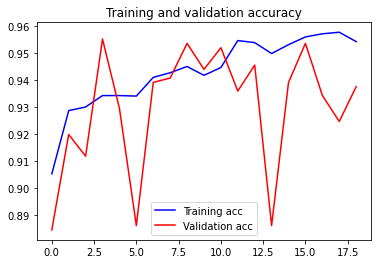

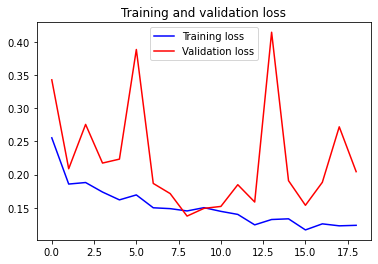

In [33]:
plot(densenet_history)

In [34]:
densenet_model.save('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201_1_2.h5')
densenet_model.load_weights('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5')

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       234
           1       0.94      0.99      0.97       390

    accuracy                           0.96       624
   macro avg       0.96      0.94      0.95       624
weighted avg       0.96      0.96      0.96       624



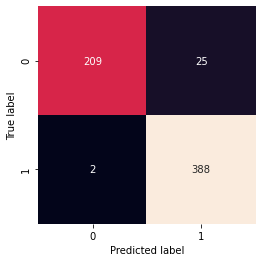

In [35]:
testing(densenet_model, test_df)

## 3) Обучение модели с FineTuning - обучение половины весов

In [36]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [37]:
print("Коо-во слоёв в base_model: ", len(base_DenseNet201.layers))

Коо-во слоёв в base_model:  707


In [38]:
base_DenseNet201.trainable = True

fine_tune_at = len(base_DenseNet201.layers)//2

for layer in base_DenseNet201.layers[:fine_tune_at]:
    layer.trainable = False

In [39]:
len(base_DenseNet201.trainable_variables)

303

In [40]:
for layer in densenet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B039E439C8> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A48A908> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B03A48AA08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B03A48FF88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A4001C8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B039FC9B08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039FC9AC8> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A411F48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039BB0708> --> True 



In [41]:
densenet_model.summary()

Model: "DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               

In [42]:
densenet_model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_DenseNet201 = ModelCheckpoint('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_DenseNet201 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [43]:
densenet_history = densenet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_DenseNet201, earlystop_DenseNet201])

Epoch 1/500
652/652 [==============================] - 171s 239ms/step - loss: 0.2115 - accuracy: 0.9164 - val_loss: 0.4342 - val_accuracy: 0.8974

Epoch 00001: val_accuracy improved from -inf to 0.89744, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 2/500
652/652 [==============================] - 153s 234ms/step - loss: 0.1771 - accuracy: 0.9335 - val_loss: 0.1714 - val_accuracy: 0.9519

Epoch 00002: val_accuracy improved from 0.89744 to 0.95192, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 3/500
652/652 [==============================] - 154s 235ms/step - loss: 0.1505 - accuracy: 0.9433 - val_loss: 0.1584 - val_accuracy: 0.9487

Epoch 00003: val_accuracy did not improve from 0.95192
Epoch 4/500
652/652 [==============================] - 153s 235ms/step - loss: 0.1302 - accuracy: 0.9563 - val_loss: 0.1898 - val_accuracy: 0.9327

Epoch 00004: val_accuracy did not improve from 0.95192
Epoch 5/500
652/652 [==

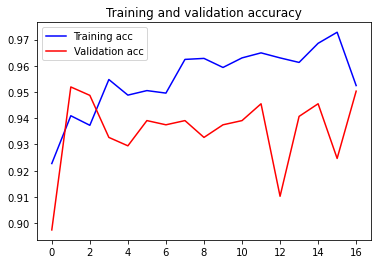

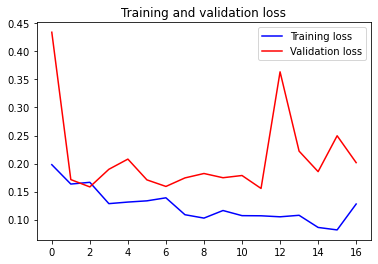

In [44]:
plot(densenet_history)

In [45]:
densenet_model.save('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201_1_3.h5')
densenet_model.load_weights('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5')

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       234
           1       0.95      0.97      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



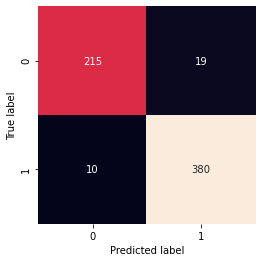

In [46]:
testing(densenet_model, test_df)

## 4) Обучение модели с FineTuning - обучение 3/4 всех весов

In [47]:
optm = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [48]:
print("Коо-во слоёв в base_model: ", len(base_DenseNet201.layers))

Коо-во слоёв в base_model:  707


In [49]:
base_DenseNet201.trainable = True

fine_tune_at = int(len(base_DenseNet201.layers)*0.25)

for layer in base_DenseNet201.layers[:fine_tune_at]:
    layer.trainable = False

In [50]:
len(base_DenseNet201.trainable_variables)

455

In [51]:
for layer in densenet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B039E439C8> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A48A908> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B03A48AA08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B03A48FF88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A4001C8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B039FC9B08> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039FC9AC8> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B03A411F48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B039BB0708> --> True 



In [52]:
densenet_model.summary()

Model: "DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               

In [53]:
densenet_model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_DenseNet201 = ModelCheckpoint('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_DenseNet201 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [54]:
densenet_history = densenet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_DenseNet201, earlystop_DenseNet201])

Epoch 1/500
652/652 [==============================] - 185s 258ms/step - loss: 0.1736 - accuracy: 0.9319 - val_loss: 0.2147 - val_accuracy: 0.9407

Epoch 00001: val_accuracy improved from -inf to 0.94071, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 2/500
652/652 [==============================] - 165s 253ms/step - loss: 0.1406 - accuracy: 0.9514 - val_loss: 0.2841 - val_accuracy: 0.8846

Epoch 00002: val_accuracy did not improve from 0.94071
Epoch 3/500
652/652 [==============================] - 165s 253ms/step - loss: 0.1355 - accuracy: 0.9526 - val_loss: 0.2360 - val_accuracy: 0.9375

Epoch 00003: val_accuracy did not improve from 0.94071
Epoch 4/500
652/652 [==============================] - 166s 254ms/step - loss: 0.1308 - accuracy: 0.9506 - val_loss: 0.2755 - val_accuracy: 0.9263

Epoch 00004: val_accuracy did not improve from 0.94071
Epoch 5/500
652/652 [==============================] - 166s 254ms/step - loss: 0.1058 - accuracy: 0.9632 - 

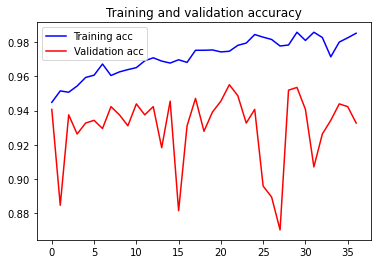

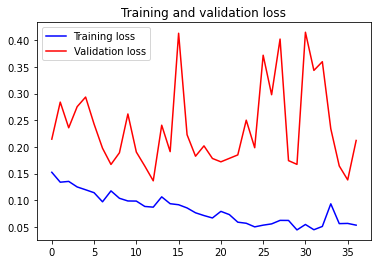

In [55]:
plot(densenet_history)

In [56]:
densenet_model.save('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201_1_4.h5')
densenet_model.load_weights('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5')

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       234
           1       0.94      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624



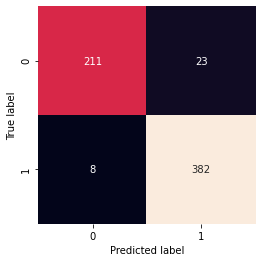

In [57]:
testing(densenet_model, test_df)

## 5) Обучение модели с FineTuning - обучение всех весов

In [58]:
optm = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [59]:
print("Коо-во слоёв в base_model: ", len(base_DenseNet201.layers))

Коо-во слоёв в base_model:  707


In [60]:
base_DenseNet201.trainable = True

In [61]:
len(base_DenseNet201.trainable_variables)

602

In [62]:
densenet_model.summary()

Model: "DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               

In [63]:
densenet_model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_DenseNet201 = ModelCheckpoint('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_DenseNet201 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [64]:
densenet_history = densenet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_DenseNet201, earlystop_DenseNet201])

Epoch 1/500
652/652 [==============================] - 242s 341ms/step - loss: 0.0702 - accuracy: 0.9746 - val_loss: 0.2204 - val_accuracy: 0.9407

Epoch 00001: val_accuracy improved from -inf to 0.94071, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 2/500
652/652 [==============================] - 219s 336ms/step - loss: 0.0856 - accuracy: 0.9745 - val_loss: 0.1881 - val_accuracy: 0.9375

Epoch 00002: val_accuracy did not improve from 0.94071
Epoch 3/500
652/652 [==============================] - 219s 336ms/step - loss: 0.0571 - accuracy: 0.9793 - val_loss: 0.4873 - val_accuracy: 0.8478

Epoch 00003: val_accuracy did not improve from 0.94071
Epoch 4/500
652/652 [==============================] - 219s 336ms/step - loss: 0.0753 - accuracy: 0.9773 - val_loss: 0.1680 - val_accuracy: 0.9503

Epoch 00004: val_accuracy improved from 0.94071 to 0.95032, saving model to B:/SKILL_FACTORY/weights/DenseNet201\best_model_DenseNet201.h5
Epoch 5/500
652/652 [==

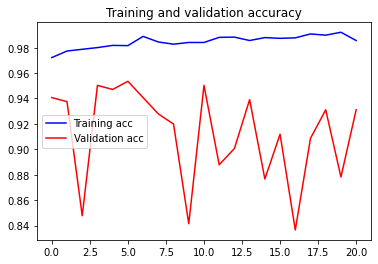

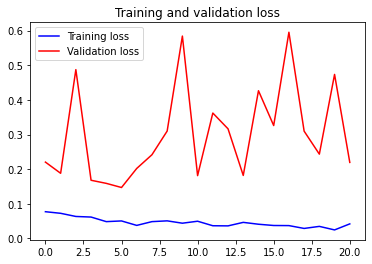

In [65]:
plot(densenet_history)

In [66]:
densenet_model.save('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201_1_5.h5')
densenet_model.load_weights('B:/SKILL_FACTORY/weights/DenseNet201/best_model_DenseNet201.h5')

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       234
           1       0.94      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.95      0.95      0.95       624



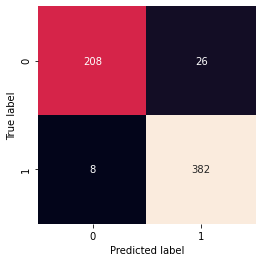

In [67]:
testing(densenet_model, test_df)

# ResNet50

In [68]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)

## 1) ResNet50 (с заморозкой всех весов)

In [69]:
tf.keras.backend.clear_session()
base_ResNet50 = ResNet50(weights = 'imagenet', include_top = False, input_shape= (224, 224, 3))


base_ResNet50.trainable = False
    
len(base_ResNet50.trainable_variables)

0

In [70]:
resnet_model = Sequential(name="ResNet50")
resnet_model.add(base_ResNet50)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(2, activation='sigmoid'))

In [71]:
resnet_model.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               328

In [72]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optm,
                     metrics=['accuracy'])

checkpoint_ResNet50 = ModelCheckpoint('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_ResNet50 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [73]:
for layer in resnet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B041C99908> --> False 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A186BC8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C73313C8> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C746A208> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C7494E08> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C74F9E48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C74F9D88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C751B448> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C7510288> --> True 



In [74]:
resnet_history = resnet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_ResNet50,earlystop_ResNet50])

Epoch 1/500
652/652 [==============================] - 153s 229ms/step - loss: 0.6014 - accuracy: 0.7263 - val_loss: 0.4193 - val_accuracy: 0.8285

Epoch 00001: val_accuracy improved from -inf to 0.82853, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 2/500
652/652 [==============================] - 147s 226ms/step - loss: 0.4395 - accuracy: 0.7927 - val_loss: 0.4245 - val_accuracy: 0.8237

Epoch 00002: val_accuracy did not improve from 0.82853
Epoch 3/500
652/652 [==============================] - 147s 226ms/step - loss: 0.4122 - accuracy: 0.8032 - val_loss: 0.4067 - val_accuracy: 0.8237

Epoch 00003: val_accuracy did not improve from 0.82853
Epoch 4/500
652/652 [==============================] - 147s 226ms/step - loss: 0.3930 - accuracy: 0.8182 - val_loss: 0.3934 - val_accuracy: 0.8526

Epoch 00004: val_accuracy improved from 0.82853 to 0.85256, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 5/500
652/652 [==============

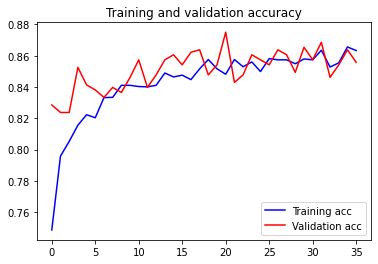

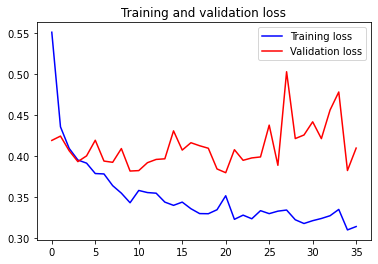

In [75]:
plot(resnet_history)

In [76]:
resnet_model.save('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50_1_1.h5')
resnet_model.load_weights('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5')

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       234
           1       0.87      0.94      0.90       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



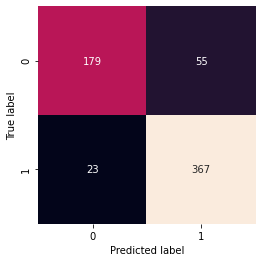

In [77]:
testing(resnet_model, test_df)

## 2) Обучение модели с FineTuning - обучение 1/4 весов

In [78]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [79]:
print("Коо-во слоёв в base_model: ", len(base_ResNet50.layers))

Коо-во слоёв в base_model:  175


In [80]:
base_ResNet50.trainable = True

fine_tune_at = int(len(base_ResNet50.layers)*0.75)

for layer in base_ResNet50.layers[:fine_tune_at]:
    layer.trainable = False

In [81]:
len(base_ResNet50.trainable_variables)

52

In [82]:
for layer in resnet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B041C99908> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A186BC8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C73313C8> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C746A208> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C7494E08> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C74F9E48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C74F9D88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C751B448> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C7510288> --> True 



In [83]:
resnet_model.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               328

In [84]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optm,
                     metrics=['accuracy'])

checkpoint_ResNet50 = ModelCheckpoint('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_ResNet50 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [85]:
resnet_history = resnet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_ResNet50,earlystop_ResNet50])

Epoch 1/500
652/652 [==============================] - 154s 230ms/step - loss: 0.4729 - accuracy: 0.7863 - val_loss: 0.8557 - val_accuracy: 0.4199

Epoch 00001: val_accuracy improved from -inf to 0.41987, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 2/500
652/652 [==============================] - 149s 228ms/step - loss: 0.3764 - accuracy: 0.8227 - val_loss: 0.5663 - val_accuracy: 0.6699

Epoch 00002: val_accuracy improved from 0.41987 to 0.66987, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 3/500
652/652 [==============================] - 149s 229ms/step - loss: 0.3771 - accuracy: 0.8253 - val_loss: 1.5273 - val_accuracy: 0.6330

Epoch 00003: val_accuracy did not improve from 0.66987
Epoch 4/500
652/652 [==============================] - 149s 229ms/step - loss: 0.3667 - accuracy: 0.8337 - val_loss: 1.1095 - val_accuracy: 0.6394

Epoch 00004: val_accuracy did not improve from 0.66987
Epoch 5/500
652/652 [==============

652/652 [==============================] - 149s 229ms/step - loss: 0.2539 - accuracy: 0.8972 - val_loss: 21.7880 - val_accuracy: 0.3750

Epoch 00039: val_accuracy did not improve from 0.85897
Epoch 40/500
652/652 [==============================] - 149s 229ms/step - loss: 0.2446 - accuracy: 0.8965 - val_loss: 6.4978 - val_accuracy: 0.3862

Epoch 00040: val_accuracy did not improve from 0.85897
Epoch 41/500
652/652 [==============================] - 149s 229ms/step - loss: 0.2381 - accuracy: 0.8958 - val_loss: 7.4514 - val_accuracy: 0.6250

Epoch 00041: val_accuracy did not improve from 0.85897
Epoch 42/500
652/652 [==============================] - 149s 229ms/step - loss: 0.2597 - accuracy: 0.8925 - val_loss: 4.0934 - val_accuracy: 0.3798

Epoch 00042: val_accuracy did not improve from 0.85897
Epoch 43/500
652/652 [==============================] - 149s 229ms/step - loss: 0.2427 - accuracy: 0.8971 - val_loss: 49.6697 - val_accuracy: 0.6250

Epoch 00043: val_accuracy did not improve from

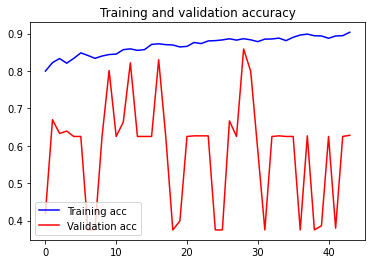

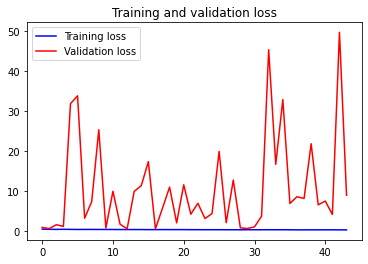

In [86]:
plot(resnet_history)

In [87]:
resnet_model.save('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50_1_2.h5')
resnet_model.load_weights('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5')

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       234
           1       0.84      0.95      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.84       624
weighted avg       0.86      0.86      0.86       624



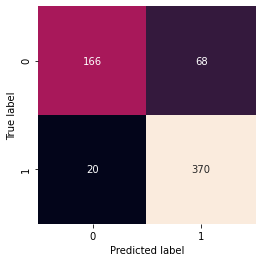

In [88]:
testing(resnet_model, test_df)

## 3) Обучение модели с FineTuning - обучение половины весов

In [89]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [90]:
print("Коо-во слоёв в base_model: ", len(base_ResNet50.layers))

Коо-во слоёв в base_model:  175


In [91]:
base_ResNet50.trainable = True

fine_tune_at = len(base_ResNet50.layers)//2

for layer in base_ResNet50.layers[:fine_tune_at]:
    layer.trainable = False

In [92]:
len(base_ResNet50.trainable_variables)

108

In [93]:
for layer in resnet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B041C99908> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A186BC8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C73313C8> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C746A208> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C7494E08> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C74F9E48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C74F9D88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C751B448> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C7510288> --> True 



In [94]:
resnet_model.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               328

In [95]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optm,
                     metrics=['accuracy'])

checkpoint_ResNet50 = ModelCheckpoint('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_ResNet50 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [96]:
resnet_history = resnet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_ResNet50,earlystop_ResNet50])

Epoch 1/500
652/652 [==============================] - 158s 235ms/step - loss: 0.4451 - accuracy: 0.8179 - val_loss: 7.1164 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 2/500
652/652 [==============================] - 151s 231ms/step - loss: 0.3542 - accuracy: 0.8375 - val_loss: 9.0778 - val_accuracy: 0.6250

Epoch 00002: val_accuracy did not improve from 0.62500
Epoch 3/500
652/652 [==============================] - 153s 234ms/step - loss: 0.3293 - accuracy: 0.8556 - val_loss: 1.8771 - val_accuracy: 0.6282

Epoch 00003: val_accuracy improved from 0.62500 to 0.62821, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 4/500
652/652 [==============================] - 163s 250ms/step - loss: 0.3140 - accuracy: 0.8586 - val_loss: 15.3238 - val_accuracy: 0.6250

Epoch 00004: val_accuracy did not improve from 0.62821
Epoch 5/500
652/652 [=============

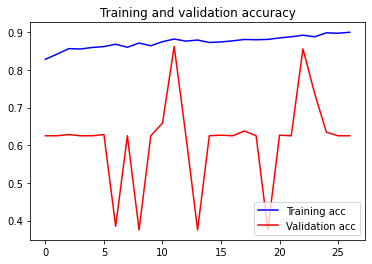

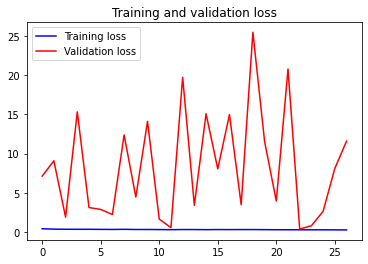

In [97]:
plot(resnet_history)

In [98]:
resnet_model.save('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50_1_3.h5')
resnet_model.load_weights('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5')

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       234
           1       0.88      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



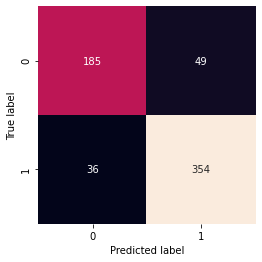

In [99]:
testing(resnet_model, test_df)

## 4) Обучение модели с FineTuning - обучение 3/4 весов

In [100]:
optm = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [101]:
print("Коо-во слоёв в base_model: ", len(base_ResNet50.layers))

Коо-во слоёв в base_model:  175


In [102]:
base_ResNet50.trainable = True

fine_tune_at = int(len(base_ResNet50.layers)*0.25)

for layer in base_ResNet50.layers[:fine_tune_at]:
    layer.trainable = False

In [103]:
len(base_ResNet50.trainable_variables)

162

In [104]:
for layer in resnet_model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x000001B041C99908> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001B03A186BC8> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C73313C8> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C746A208> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C7494E08> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001B1C74F9E48> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C74F9D88> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x000001B1C751B448> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x000001B1C7510288> --> True 



In [105]:
resnet_model.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               328

In [106]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optm,
                     metrics=['accuracy'])

checkpoint_ResNet50 = ModelCheckpoint('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_ResNet50 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [107]:
resnet_history = resnet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_ResNet50,earlystop_ResNet50])

Epoch 1/500
652/652 [==============================] - 183s 271ms/step - loss: 0.3675 - accuracy: 0.8436 - val_loss: 0.4008 - val_accuracy: 0.8638

Epoch 00001: val_accuracy improved from -inf to 0.86378, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 2/500
652/652 [==============================] - 166s 255ms/step - loss: 0.2750 - accuracy: 0.8880 - val_loss: 1.2006 - val_accuracy: 0.4103

Epoch 00002: val_accuracy did not improve from 0.86378
Epoch 3/500
652/652 [==============================] - 155s 237ms/step - loss: 0.2674 - accuracy: 0.8863 - val_loss: 0.4125 - val_accuracy: 0.8029

Epoch 00003: val_accuracy did not improve from 0.86378
Epoch 4/500
652/652 [==============================] - 152s 233ms/step - loss: 0.2485 - accuracy: 0.8952 - val_loss: 0.5655 - val_accuracy: 0.7788

Epoch 00004: val_accuracy did not improve from 0.86378
Epoch 5/500
652/652 [==============================] - 153s 235ms/step - loss: 0.2908 - accuracy: 0.8701 - val_lo

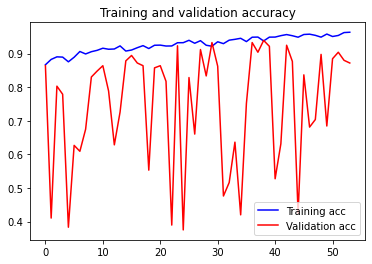

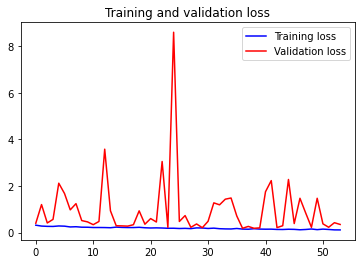

In [108]:
plot(resnet_history)

In [109]:
resnet_model.save('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50_1_4.h5')
resnet_model.load_weights('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5')

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       234
           1       0.94      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.94       624
weighted avg       0.94      0.94      0.94       624



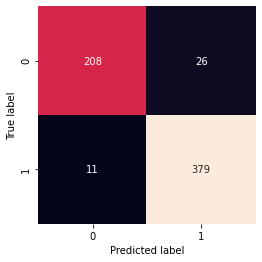

In [110]:
testing(resnet_model, test_df)

## 5) Обучение модели с FineTuning - обучение всех весов

In [111]:
optm = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [112]:
print("Коо-во слоёв в base_model: ", len(base_ResNet50.layers))

Коо-во слоёв в base_model:  175


In [113]:
base_ResNet50.trainable = True

In [114]:
len(base_ResNet50.trainable_variables)

212

In [115]:
resnet_model.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               328

In [116]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optm,
                     metrics=['accuracy'])

checkpoint_ResNet50 = ModelCheckpoint('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_ResNet50 = EarlyStopping(monitor='val_accuracy',
                          patience=15,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [117]:
resnet_history = resnet_model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_ResNet50,earlystop_ResNet50])

Epoch 1/500
652/652 [==============================] - 166s 245ms/step - loss: 0.2448 - accuracy: 0.9012 - val_loss: 47.5621 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 2/500
652/652 [==============================] - 159s 243ms/step - loss: 0.1651 - accuracy: 0.9369 - val_loss: 1.8804 - val_accuracy: 0.6394

Epoch 00002: val_accuracy improved from 0.62500 to 0.63942, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 3/500
652/652 [==============================] - 163s 250ms/step - loss: 0.1592 - accuracy: 0.9436 - val_loss: 0.1853 - val_accuracy: 0.9247

Epoch 00003: val_accuracy improved from 0.63942 to 0.92468, saving model to B:/SKILL_FACTORY/weights/ResNet50\best_model_ResNet50.h5
Epoch 4/500
652/652 [==============================] - 162s 249ms/step - loss: 0.1399 - accuracy: 0.9518 - val_loss: 0.2454 - val_accuracy: 0.8910

Epoch 00004

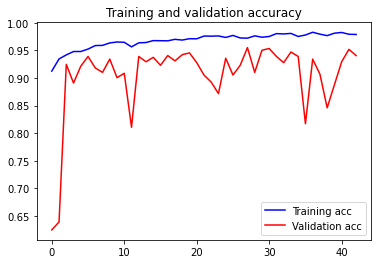

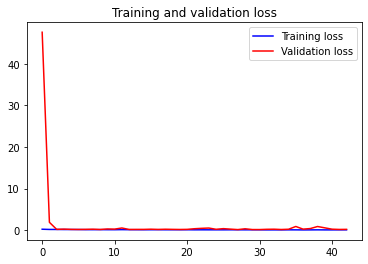

In [118]:
plot(resnet_history)

In [119]:
resnet_model.save('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50_1_5.h5')
resnet_model.load_weights('B:/SKILL_FACTORY/weights/ResNet50/best_model_ResNet50.h5')

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       234
           1       0.95      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624



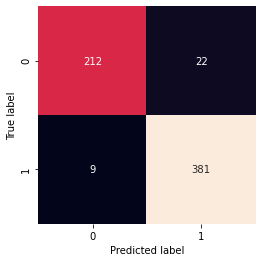

In [120]:
testing(resnet_model, test_df)

In [4]:
from scipy import interpolate

In [33]:
def all_plot(e1,e2,e3,e4,e5):
    epochs = range(55)
# ``'b'``          blue
# ``'g'``          green
# ``'r'``          red
# ``'c'``          cyan
# ``'m'``          magenta
# ``'y'``          yellow
# ``'k'``          black
# ``'w'``          white


#     e1 = pd.Series(e1).rolling(3).mean()
#     e2 = pd.Series(e2).rolling(3).mean()
#     e3 = pd.Series(e3).rolling(3).mean()
#     e4 = pd.Series(e4).rolling(3).mean()
#     e5 = pd.Series(e5).rolling(3).mean()
    
    plt.figure(figsize=(32,9))
    plt.plot(range(len(e1)), e1, 'b', label='1st stage')
    plt.plot(range(len(e2)), e2, 'k', label='2nd stage')
    plt.plot(range(len(e3)), e3, 'r', label='3rd stage')
    plt.plot(range(len(e4)), e4, 'c', label='4th stage')
    plt.plot(range(len(e5)), e5, 'y', label='5th stage')
    plt.title('Demonstration of all stages')
    plt.legend(prop={'size': 25})

    plt.show()

In [34]:
DN_val_acc_1 = [0.9038, 0.9119, 0.9135, 0.9247, 0.9263, 0.9103, 0.9167, 0.9279, 0.9247, 0.9183, 0.9199, 0.9231, 0.9199,
                0.9167, 0.9263, 0.9263, 0.9327, 0.9311, 0.9359, 0.9295, 0.9279, 0.9311, 0.9311, 0.9311, 0.9295, 0.9071,
                0.9231, 0.9215, 0.9231, 0.9327, 0.9311, 0.9247, 0.9343, 0.9391, 0.9423, 0.9295, 0.9183, 0.9231, 0.9263, 
                0.9359, 0.9359, 0.9199, 0.9311, 0.9215, 0.9247, 0.9295, 0.9279, 0.9327, 0.9215, 0.9279]

DN_val_acc_2 = [0.8846, 0.9199, 0.9119, 0.9551, 0.9295, 0.8862, 0.9391, 0.9407, 0.9535, 0.9439, 0.9519, 0.9359, 0.9455,
                0.8862, 0.9391, 0.9535, 0.9343, 0.9247, 0.9375]

DN_val_acc_3 = [0.8974, 0.9519, 0.9487, 0.9327, 0.9295, 0.9391, 0.9375, 0.9391, 0.9327, 0.9375, 0.9391, 0.9455, 0.9103, 
                0.9407, 0.9455,0.9247, 0.9503]

DN_val_acc_4 = [0.9407, 0.8846, 0.9375, 0.9263, 0.9327, 0.9343, 0.9295, 0.9423, 0.9375, 0.9311, 0.9439, 0.9375, 0.9423,
                0.9183, 0.9455, 0.8814, 0.9311, 0.9471, 0.9279, 0.9391, 0.9455, 0.9551, 0.9487, 0.9327, 0.9407, 0.8958,
                0.8894, 0.8702, 0.9519, 0.9535, 0.9407, 0.9071, 0.9263, 0.9343, 0.9439, 0.9423, 0.9327]

DN_val_acc_5 = [0.9407, 0.9375, 0.8478, 0.9503, 0.9471, 0.9535, 0.9407, 0.9279, 0.9199, 0.8413, 0.9503, 0.8878, 0.9006,
                0.9391, 0.8766, 0.9119, 0.8365, 0.9087, 0.9311, 0.8782, 0.9311]

In [35]:
RN_val_acc_1 = [0.8285, 0.8237, 0.8237, 0.8526, 0.8413, 0.8381, 0.8333, 0.8397, 0.8365, 0.8462, 0.8574, 0.8397, 0.8478,
                0.8574, 0.8606, 0.8542, 0.8622, 0.8638, 0.8478, 0.8542, 0.8750, 0.8429, 0.8478, 0.8606, 0.8574, 0.8542,
                0.8638, 0.8606, 0.8494, 0.8654, 0.8574, 0.8686, 0.8462, 0.8542, 0.8638, 0.8558]

RN_val_acc_2 = [0.4199, 0.6699, 0.6330, 0.6394, 0.6250, 0.6250, 0.3750, 0.3750, 0.6250, 0.8013, 0.6250, 0.6635, 0.8221,
                0.6250, 0.6250, 0.6250, 0.8301, 0.6250, 0.3750, 0.3990, 0.6250, 0.6266, 0.6266, 0.6266, 0.3750, 0.3750,
                0.6667, 0.6250, 0.8590, 0.7997, 0.5881, 0.3750, 0.6250, 0.6266, 0.6250, 0.6250, 0.3750, 0.6266, 0.3750,
                0.3862, 0.6250, 0.3798, 0.6250, 0.6282]

RN_val_acc_3 = [0.6250, 0.6250, 0.6282, 0.6250, 0.6250, 0.6282, 0.3846, 0.6250, 0.3750, 0.6250, 0.6587, 0.8622, 0.6250,
                0.3750, 0.6250, 0.6266, 0.6250, 0.6378, 0.6250, 0.3750, 0.6266, 0.6250, 0.8558, 0.7372, 0.6346, 0.6250,
                0.6250]

RN_val_acc_4 = [0.8638, 0.4103, 0.8029, 0.7788, 0.3830, 0.6266, 0.6090, 0.6747, 0.8301, 0.8478, 0.8638, 0.7885, 0.6282,
                0.7260, 0.8782, 0.8942, 0.8718, 0.8638, 0.5529, 0.8574, 0.8638, 0.8173, 0.3894, 0.9231, 0.3750, 0.8285,
                0.6603, 0.9119, 0.8333, 0.9327, 0.8622, 0.4760, 0.5160, 0.6362, 0.4199, 0.7516, 0.9327, 0.9038, 0.9391,
                0.9215, 0.5272, 0.6314, 0.9247, 0.8766, 0.4247, 0.8365, 0.6811, 0.7035, 0.8974, 0.6843, 0.8846, 0.9038,
                0.8798, 0.8718]

RN_val_acc_5 = [0.6250, 0.6394, 0.9247, 0.8910, 0.9215, 0.9391, 0.9183, 0.9103, 0.9343, 0.9006, 0.9087, 0.8109, 0.9391,
                0.9295, 0.9375, 0.9231, 0.9407, 0.9311, 0.9423, 0.9455, 0.9279, 0.9054, 0.8926, 0.8718, 0.9359, 0.9054,
                0.9231, 0.9551, 0.9103, 0.9503, 0.9535, 0.9391, 0.9279, 0.9471, 0.9391, 0.8173, 0.9343, 0.9071, 0.8462,
                0.8878, 0.9295, 0.9519, 0.9407]

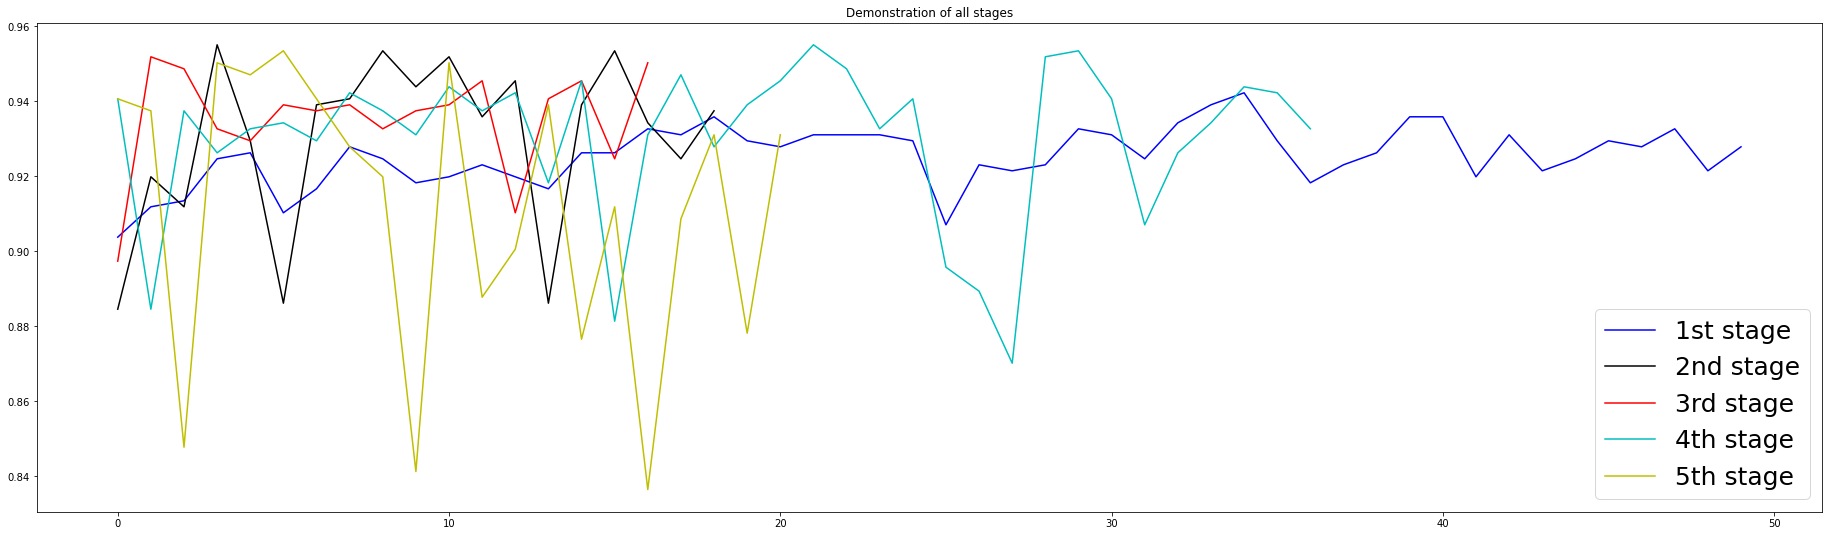

In [36]:
all_plot(DN_val_acc_1,DN_val_acc_2,DN_val_acc_3,DN_val_acc_4,DN_val_acc_5)

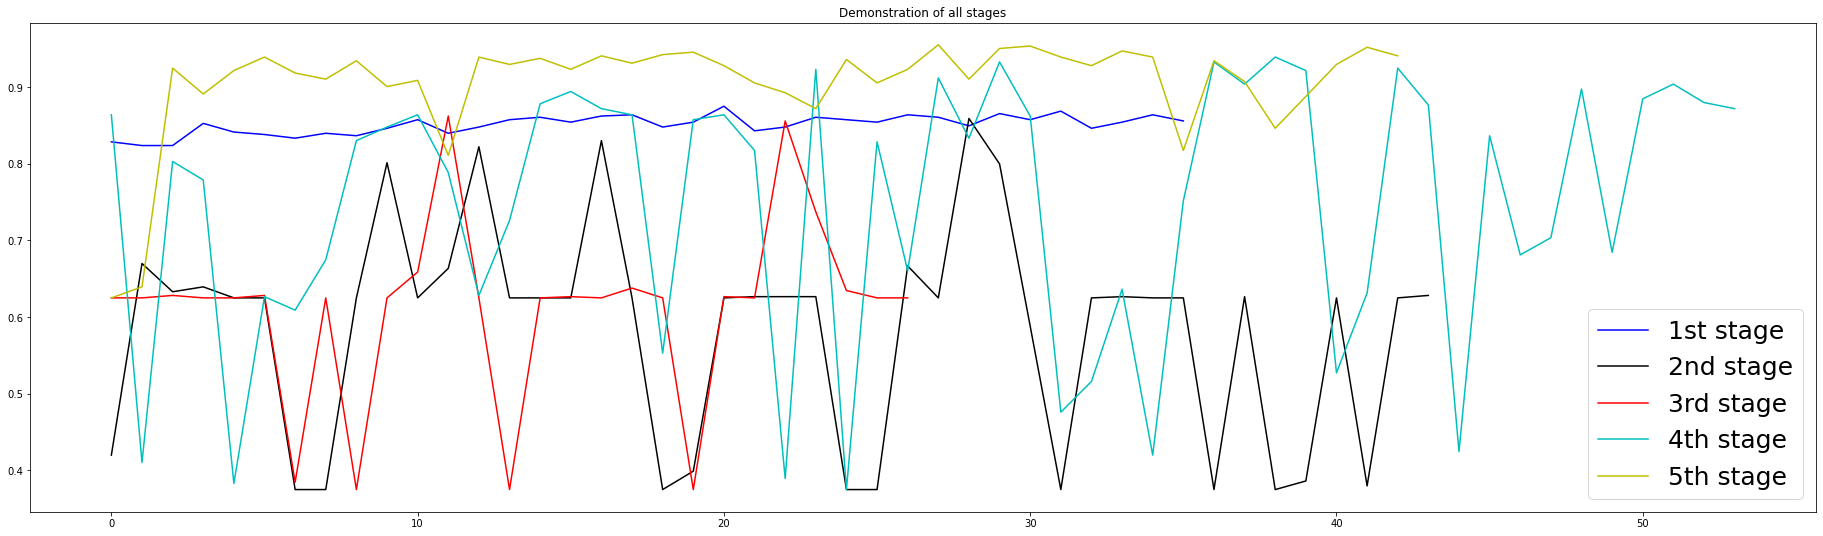

In [37]:
all_plot(RN_val_acc_1,RN_val_acc_2,RN_val_acc_3,RN_val_acc_4,RN_val_acc_5)